## Pokemon 3: Return of the Kingler

#### Hayden Burger, Corinne Desroches, David Lee

### Introduction

Pokémon, as a franchise, is a battle and adventure simulator where a player can catch, train, and battle with creatures called pokémon. Each pokémon has a type, speed, attack, defense, moveset, and a number of other stats that determine its strengths and weaknesses in battle. Every 'generation' of Pokémon games introduces new pokémon, moves, and mechanics that increase the complexity of the game. For this project we retained just the first 151 Pokémon from the first generation, corresponding to the video games of Pokémon Red, Blue, and Yellow. We also are using the Elite Four from those games as our metric for an effective team of pokémon. These elite trainers are used in the game as a type of final boss, and are billed as the strongest trainers in the game.

On previous iterations of this project, we have built up from a 1v1 simulation of each attack and defense, all the way to teams of 6 pokémon battling against sequential enemy teams. We have remained as faithful to the game as possible, using the in-game battle equations and stats. We have also used the in-game type advantages and disadvantages to determine the effectiveness of each attack. We did not use move limits (PP), modified traits (IV or EV), items, or switching pokémon in battle. We have used all the status conditions that were applicable in this generation (sleep, confusion, poison, dig, etc).


### Data Gathering

Using `requests` and the **PokeAPI**, we were able to recreate the data used for the `pokemon_module.py` file. This was better than the previous method of downloading CSVs from various sources such as Kaggle, Bulbapedia, and Serebii. The API allowed us to get the most up-to-date information on the pokémon, including their stats, types, and moves. More importantly, it provided the data in a common format that limited the amount of data cleaning we had to do. Lastly, the API allowed us to get the data in a way that was easily repeatable, which is important for the future work we would like to do with this project - such as adding more generations of pokémon, or adding more elite trainers to battle against.

Example of the API call:
```python
base_url = 'https://pokeapi.co/api/v2/generation/1'
response = requests.get(base_url)
gen1_data = response.json()

gen_1_pokemon = []
for i in gen1_data['pokemon_species']:
    gen_1_pokemon.append(i['name'])

...

 Fetch Pokemon data
pk = []
for i in gen_1_pokemon:
    url = f'https://pokeapi.co/api/v2/pokemon/{i}'
    pk_data = requests.get(url).json()
    
    pokemon_info = {
        'name': pk_data['name'],
        'pokedex_number': pk_data['id'],
        'generation': 1 if pk_data['id'] <= 151 else 'N/A',
        'type1': pk_data['types'][0]['type']['name'],
        'type2': pk_data['types'][1]['type']['name'] if len(pk_data['types']) > 1 else 'N/A',
        'height_(m)': pk_data['height'] / 10,
        'weight_(kg)': pk_data['weight'] / 10,
        'base_total': sum(stat['base_stat'] for stat in pk_data['stats']),
        'hp': pk_data['stats'][0]['base_stat'],
        'attack': pk_data['stats'][1]['base_stat'],
        'defense': pk_data['stats'][2]['base_stat'],
        'sp_attack': pk_data['stats'][3]['base_stat'],
        'sp_defense': pk_data['stats'][4]['base_stat'],
        'speed': pk_data['stats'][5]['base_stat'],
        'image_url': pk_data['sprites']['other']['official-artwork']['front_default']
    }
```

The full script can be found in the `Pk_Data_Retrieve.py` file. The output of `Pk_Data_Retrieve.py` is the CSV files `moves.csv` and `pokemon.csv` which contains all the information we need to run the simulation. This CSV file is then used in the `pokemon_module.py` file to run the simulation.

### Running Random Team Battles

#### Creating Teams

In order to run multiple Pokemon teams against the Elite Four, we first need to select which Pokemon make up a team. We chose to create random teams, using `np.random.choice` to select 6 from the Generation 1 Pokemon. The function `random_team_names` below samples with replacement, meaning it's possible to have multiple of the same type of Pokemon, just like in the games. It calls from `pokemon_dict`, which is a dictionary referencing each Pokemon class by their name. It's a function of `pokemon_module` and it can be called via `pokemon_dict = pk.create_pokemon_dict()`.

```python
def random_team_names(n):
    '''Generates n pokemon names'''
    team = []
    for i in range(n):
        pokemon_name = np.random.choice(list(pokemon_dict.keys()))
        team.append(pokemon_name)
    return team

def save_teams(n,filename):
    '''writes n random teams to CSV file'''
    with open(filename,'w',newline='') as file:
        writer = csv.writer(file)
        for i in range(n):
            team = random_team_names(6) 
            writer.writerow(team)
    return 
```      
The `save_teams` function will call the other function to create teams of six, and write each to a line in a CSV. For early iterations, we just called `save_teams` with a filename to create a file of n teams. However, for very large numbers, the process is slow, and the CSV is potentially unviable. (Programs that open CSVs have row limits, and most software is limited to about 1 million lines.)

So the next step was to create a way to split this process up. The python script `create_teams.py` contains the functions above, and calls as an argument a CSV index. It will create a CSV of 100,000 teams, named with that index using the `fstring` functionality of python:

```python
filename = f'Input_data_files/random_teams_{csv_index}.csv'
```
In order to access the input, it calls the module `sys`. Each argument when called from a command line (or batch script) becomes part of the variable sys.argv. The handling in `create_teams.py` will take the input if it exists, and otherwise will use a default team and set the index to 0. This was run in the NPS High Performance Computing System, Hamming, using slurm commands. 


#### Hamming and Slurm

If you have a Hamming account, Hamming can be accessed from a terminal with the command `FIND COMMAND`. The terminal MobaXterm was used, as it has a simple GUI that allows easy uploading and downloading of files.

On Hamming, we used a virtual environment for consistent access to the required python modules. This environment can be created via the command `python -m venv {environment path}`. Specifically, we used an environment `comp3`, created for the class and located in the smallwork part of Hamming. The environment was activated using `source /smallwork/$USER/comp3/bin/activate`.

The required modules to have installed are pandas and numpy. After loading python via `load lang/python`, these can be pip installed, e.g. `python -m pip install pandas`. 

After we have the virtual environment, we can run batch scripts that access it. The script used to create teams, calling `create_teams.py`, is below.

```bash
#!/bin/sh

#SBATCH --job-name create_random_csv
#SBATCH --array=0-99
#SBATCH --output=Output_data_files/out_input.txt

. /etc/profile
module load lang/python
## load the comp3 virtual environment
source /smallwork/$USER/comp3/bin/activate

## arguments:  team number, number of runs
python create_teams.py ${SLURM_ARRAY_TASK_ID}
```

The top line indicates that it is a bash script. The `#SBATCH` lines are commands for how to execute the script. The first defines the job name, the second runs the script 100 times, and the last directs the output from the command line to a txt file. The python script is called with `${SLURM_ARRAY_TASK_ID}` as an argument, which will be one of the numbers from 0 to 99. This will create 100 CSVs of 100,000 lines each, each line a team of six random pokemon.

The batch file is run from the command line of the terminal. First, `salloc` is called to allocate computing resources for the task. Then the script is run with `sbatch create_input.sh`.

#### Running the Scenario

The script `pokemon_script.py` imports `pokemon_module.py` as `pk` in order to utilize its functions. It takes as input a team index number and the number of battles to run for each team. If the input isn't provided, both are defaulted to one.

```python
#Arguments: poke_index, n_fights
if len(sys.argv) >=2:
    poke_index = int(sys.argv[1])
    n_fights = int(sys.argv[2])
else:
    #Not enough inputs
    poke_index = 1
    n_fights = 1
```

The script will load the team from the CSV, based on the index. `math.floor` is used to identify which CSV to load to find the team name. For teams 1-100,000, the random_teams_0.csv contains the appropriate team, and so on. The appropriate CSV is saved as a dataframe. The modulus operator `%` is used to find which row in the dataframe corresponds to the team. For example, team 100002 is the second team of its CSV and corresponding dataframe.

```python
#Load player team from CSV
team_index = math.floor((poke_index-1)/100000)
infilename = "Input_data_files/random_teams_{team_index}.csv"
teams = pd.read_csv(infilename,header=None)
csv_loc = (poke_index%100000)-1
player_team = teams.loc[csv_loc].to_list()
```

The Pokemon names of the team are saved to a list.

After that the script defines lists for each of the elite four teams. We then use the pokemon_module function `create_pokemon_objects` to create pokemon classes for each team. This turns a list of pokemon names into a dictionary of pokemon class objects, indexed by their name. This can be called with `pk.create_pokemon_objects({pokemon list})`. The player team and each team in the elite four is converted to a dictionary, and the elite four dictionaries are saved in a list called `elite`.

The battle is then run using the code below, again referencing a pokemon_module function. `run_elite` will run pokemon battles for every member of the player team against every member of an opponent team, for each of the opponent teams. It is designed to take a list of exactly four teams for the elite four, and will print an error for a different team construction. This `run_elite` function is run inside a locally defined function called sim_elite, which produces a dataframe for all the runs of the player team against the elite four.

```python
#function to run num_runs battles and save results to dataframe
def sim_elite(team,elite,num_runs=10):
    results = pd.DataFrame(columns=['Result','Time','Winner','Winner List'])
    for i in range(num_runs):
        result,time,teamname,winnerlist = pk.run_elite(team,elite,verbose=False,roundreset=False)
        results.loc[i] = [result,time,teamname,winnerlist]
    return results
```

Results are saved in the form of (Result, Time, Winner, Winner List). The `Result` is a 1 or 0 for whether the player team wins or loses, respectively. `Time` is the amount of time the battle takes, assuming each round is six seconds. `Winner` returns the winning team, whether that is the player ("Champion") or a member of the Elite Four. `Winner List` is a list of battle outcomes in order, so for every 1v1 pairing it will have either the name of the winning pokemon or "Draw". 

After running the designated number of battles, `pokemon_script.py` will aggregate the results to a single line containing: a list of team members, the "efficiency" (number of wins/average time), number of wins, average win time, standard deviation of the win time, average lose time, standard deviation of the lose time, number of losses to each Elite Four team (Lorelei, Bruno, Agatha, and Lance), the "nemesis", which is the pokemon that the team lost to most consistently, and the number of times that team lost to that nemesis.

The results are written to an csv using the pandas ability `.to_csv`. By aggregating the data of multiple battles before saving it, each resulting csv consists of a single line to save storage.

```python
file_name = f"./Output_data_files/results_team_{poke_index}.csv"
collectedresults_df.to_csv(file_name)
```

`pokemon_script.py` is run with the batch script `pokemon_battle.sh`. The script creates a job named `HEB_pokemonbattle`, divided into `100,000` tasks, and sends any output to `out_battle.txt`. It loads python, and activates the comp3 virtual environment that was created on Hamming in this course. 

```bash
#!/bin/sh

#SBATCH --job-name HEB_pokemonbattle
#SBATCH --array=0-99999
#SBATCH --output=Output_data_files/out_battle.txt

. /etc/profile
module load lang/python
## load the comp3 virtual environment
source /smallwork/$USER/comp3/bin/activate

python pokemon_battle.py ${SLURM_ARRAY_TASK_ID} 100
```

Note: the slurm array value cannot go to 6 digits. The highest value is 99,999. Thus, while the intent was to run 10 million teams, it was only possible to do 100,000 in a single command.

#### Collecting Results

The code above will produce 100,000 CSVs of a single line each, named `results_team_{poke_index}`. They need to be collected into a single CSV. `Combine_output.py` will take a CSV index as input, much like the create_teams script. The index will dictate which results to read to a dataframe, and will write to a CSV with the index name. With csv_index =0, the code will save all team results from 0 to 99,999 to a file Team_Summary_0.csv. If you were to have 10 million teams, you would produce 100 of these files, matching the number of input CSVs.

The code relies on the `glob` module to search the output folder for all the filenames that follow the format. For each one, the team number is retrieved and divided by 100,000 to identify which chunk of data it belongs to. If that matches the `csv_index`, the file is loaded to a dataframe and appended, again using the pandas `to_csv` method.

```python
paths = glob.glob("./Output_data_files/results_team_*.csv")
```

The code is from a batch file, called with `sbatch combine_output.sh`. Structurally, it mirrors `create_input.sh`.

```bash
#!/bin/sh

#SBATCH --job-name summarize_pokemon
#SBATCH --array=0-99
#SBATCH --output=Output_data_files/out_summarize.txt

. /etc/profile
module load lang/python
## load the comp3 virtual environment
source /smallwork/$USER/comp3/bin/activate

## arguments:  team number, number of runs
python Combine_output.py ${SLURM_ARRAY_TASK_ID}
```

### Streamlit

**Streamlit** was a helpful tool for visualizing the data. The `vis.py` file contains the code for the app and is called locally by running `streamlit run vis.py` from the command line. The app will open in a local browser window, and will display the data in a user-friendly way. Additionally, the app is hosted online via the **Streamlit** platform at [Pokemon 3](https://pokemon3.streamlit.app). There are 6 pages of interactable data visualizations which summarize the conclusions of our 3 projects thus far. Pages 1, 2, and 3 cover the results from the 1v1 battles introduced with our first project - Pokemon: Near Peer Battle Simulator. Pages 4 and 5 summarize the results from our second project - Pokemon 2: Electric Boogaloo. In that project we tested 11 teams of 6 - chosen by us - against the Elite Four. The final page, page 6, covers the results from this project - Pokemon 3: Return of the Kingler. In this project we tested 100,000 teams of 6 - chosen at random - against the Elite Four. Furthermore, on page 3 you can try out your own pokemon 1v1 battle at any level using the slider and on page 5 you can try out your own team of 6 against the Elite Four.

Below is an example of the streamlit app.

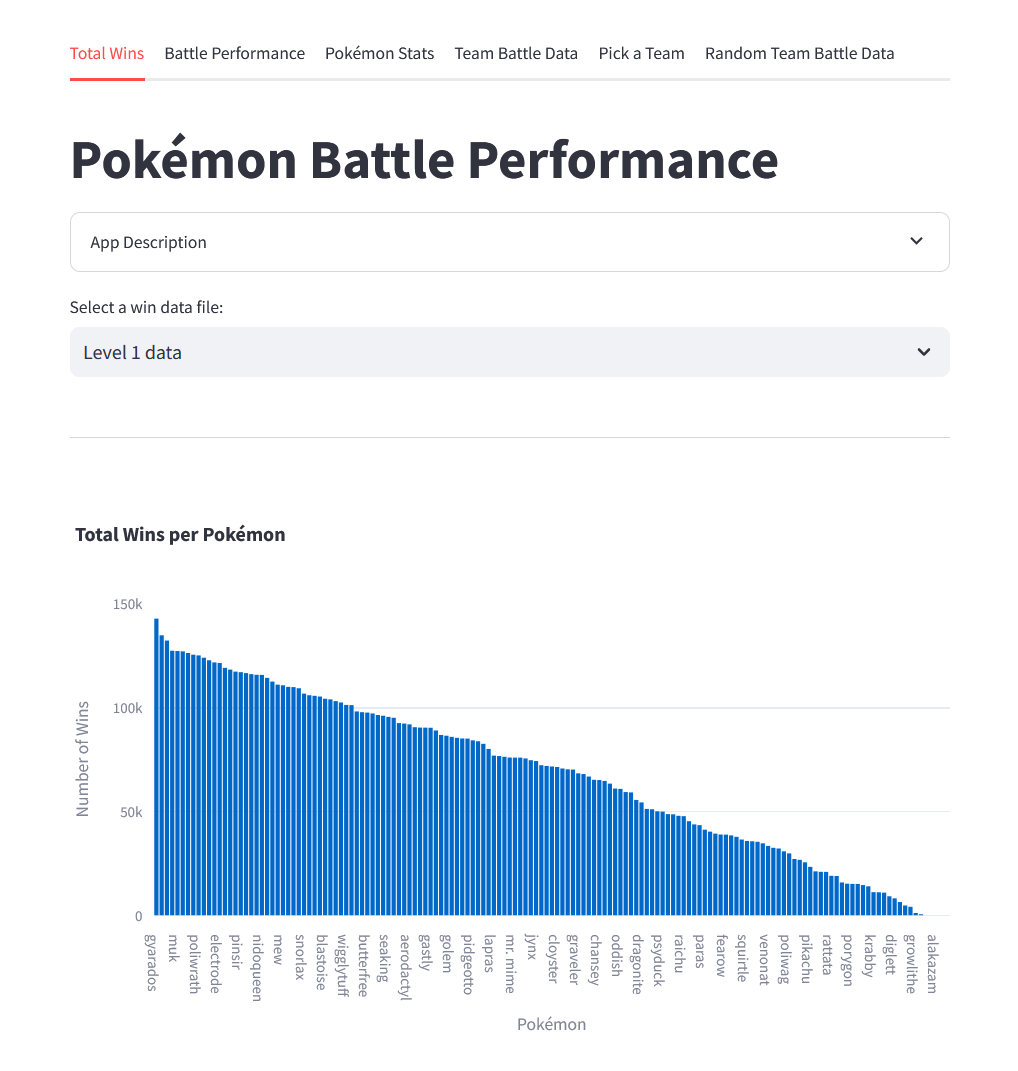 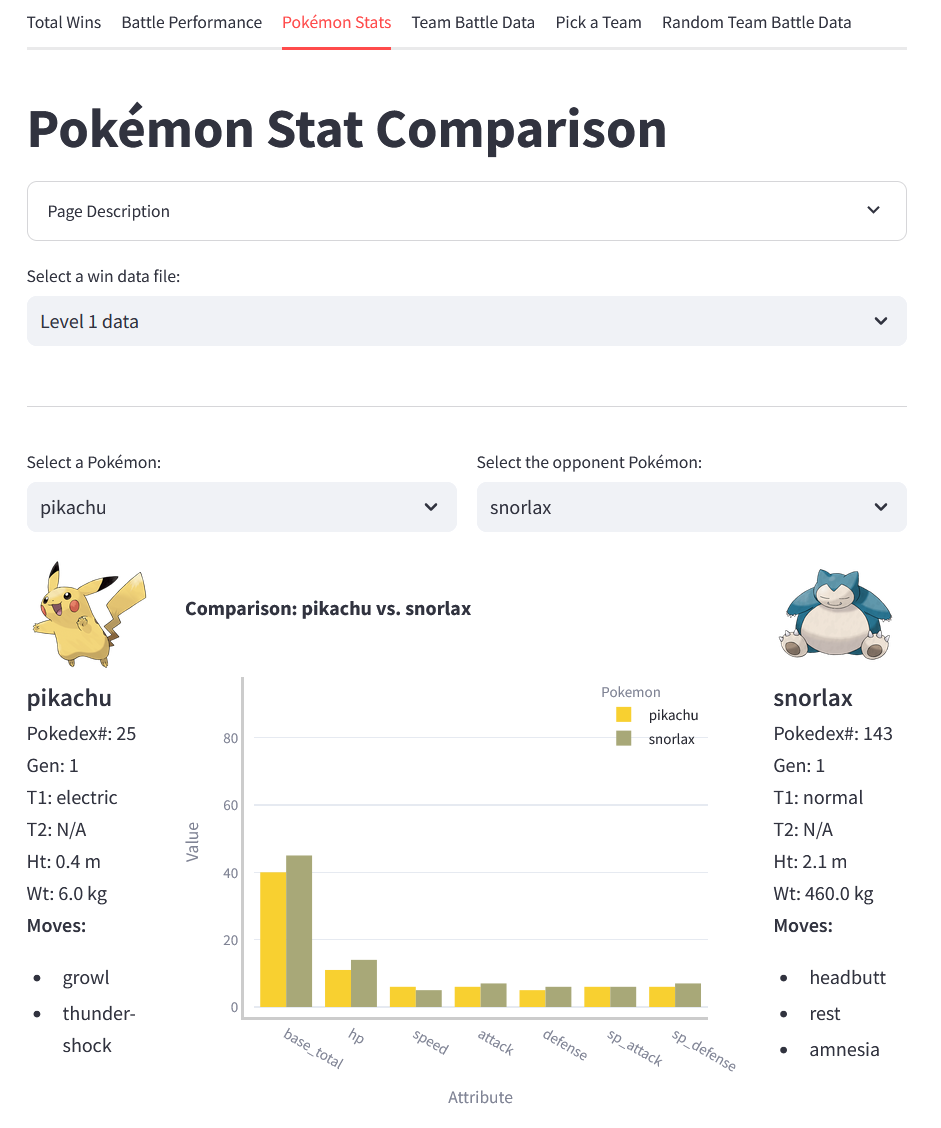

The streamlit app was put together using a combination of html coding, plotly graphs, and streamlit widgets. An example of some of the code is show below:

##### Page 1 code - representing the left image above

```python
with page1:
    st.title('Pokémon Battle Performance')
    
    # Add App description
    with st.expander("App Description"):
        st.markdown("""
                    ## Simulation Overview

                    This app showcases the results of 1,000 Monte Carlo simulated runs of each Generation 1 Pokémon battling against each other. With 151 Pokémon, the wins were recorded in a pandas dataframe of size 151x151, where each cell takes a value between 0 and 1000, representing the number of wins Pokémon A has against Pokémon B.

                    ### Assumptions/Restrictions

                    For our simulation, we made the following assumptions/restrictions:

                    - Every Pokémon was at level 1.
                    - Each Pokémon only has access to moves it knows at level 1.
                    - Each move is randomly selected on its turn if it has access to it.
                    - PP for moves was not included; instead, we called it a draw after 100 rounds of combat.
                    """, unsafe_allow_html=False)
        
    # Calculate total wins for each Pokémon
    battle_data_key = st.selectbox('Select a win data file:', options=file_options_wins, key='file_select')  # Dropdown menu for file selection
    battle_data = load_data(file_options_wins[battle_data_key], index_col='name')
    level = int(battle_data_key.split(' ')[1])
    
    pokemon_data = pk.levelup(level1_pokemon_data, level=level)
    
    total_wins = battle_data.sum(axis=1).sort_values(ascending=False).reset_index()
    total_wins.columns = ['name', 'Total Wins']  # Renaming for clarity
    # Merge total wins with pokemon_data on the Pokémon name
    merged_data = pd.merge(pokemon_data.reset_index(), total_wins, on='name')
    
    st.write("---")  # Add a separator
    plot_total_wins(battle_data)
    st.write("---")  # Adds a visual separator

    # Allow user to select an attribute to compare against Total Wins
    attribute_options = ['type1', 'type2', 'base_total', 'hp', 'speed', 'attack', 'defense', 'sp_attack', 'sp_defense'] # Assuming 'name' is not in pokemon_data columns
    selected_attribute = st.selectbox("Select an attribute to compare with Total Wins:", options=attribute_options, key='attribute_select_1')
    plot_total_wins_vs_attribute(merged_data, selected_attribute)
    st.write("---")  # Add a separator for visual clarity
```

### Data Presentation
Some data visualizations that one could create inside Excel or JMP.

 Gengar is the common thread of every team with a win percentage of 65% or more against the Elite Four.
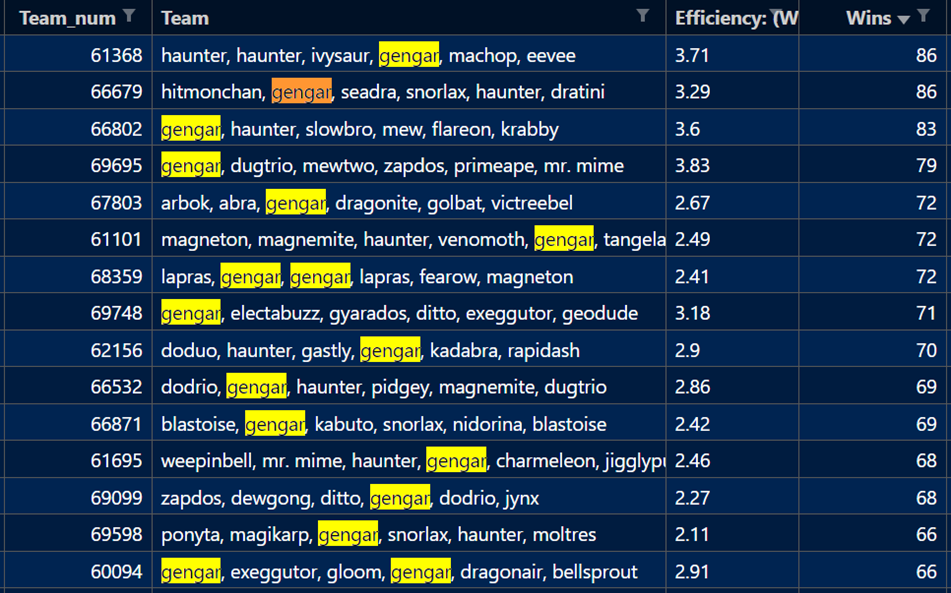

Here is the top team without a Gengar, showcasing a win percentage of 65%.
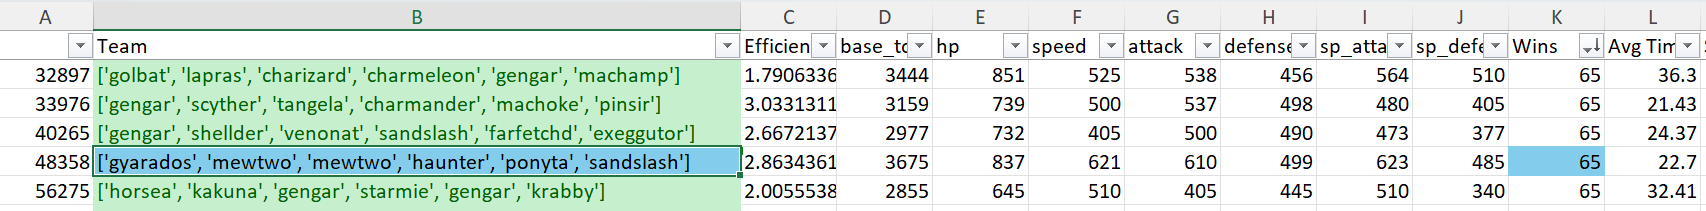

Using a pivot table on `Random_Team_Summary.csv`, we can see how the nemesis pokemon drove the losses to each of the Elite Four.
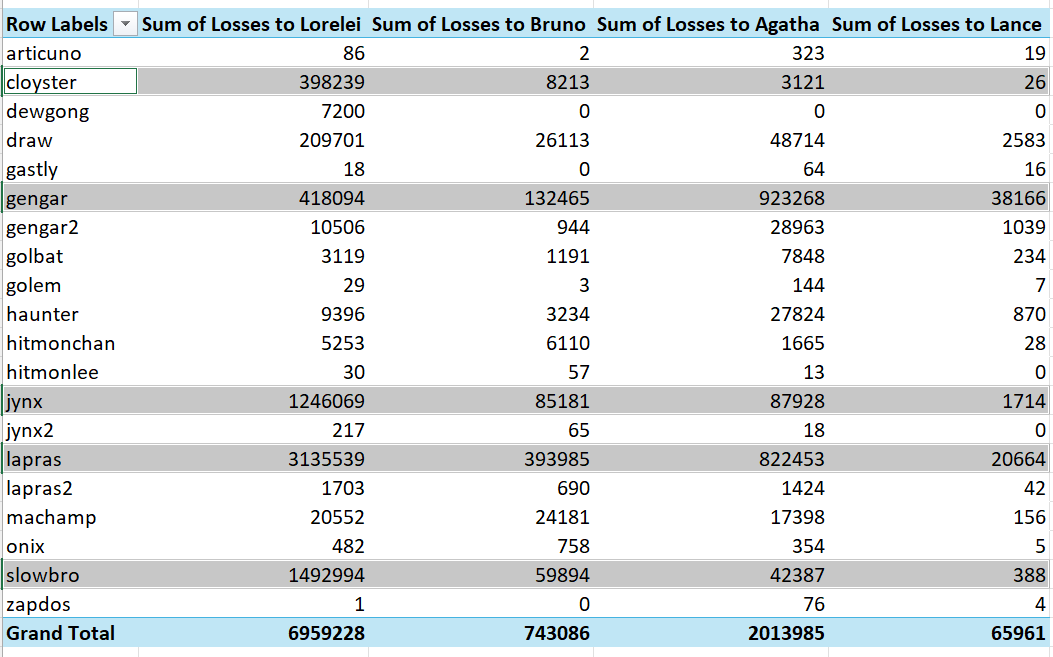

Of the teams with 0 total wins, here's how those losses were distributed to the Elite Four <br>
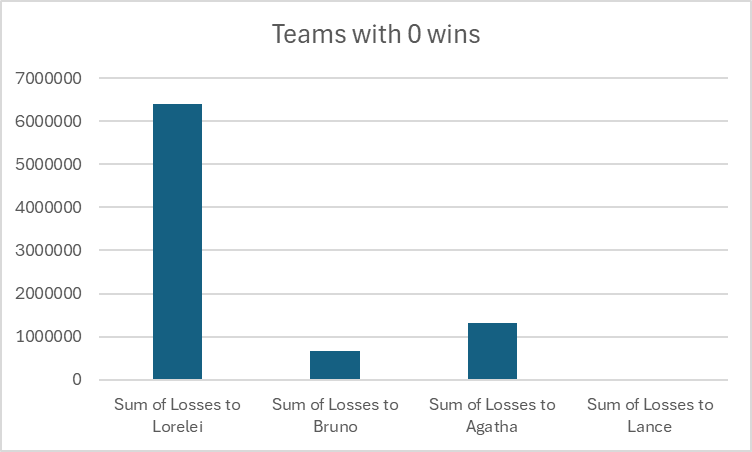

Using JMP to fit trend lines to the data visualizations in the streamlit app, we can see how the number of wins and the various stats are correlated loosely.
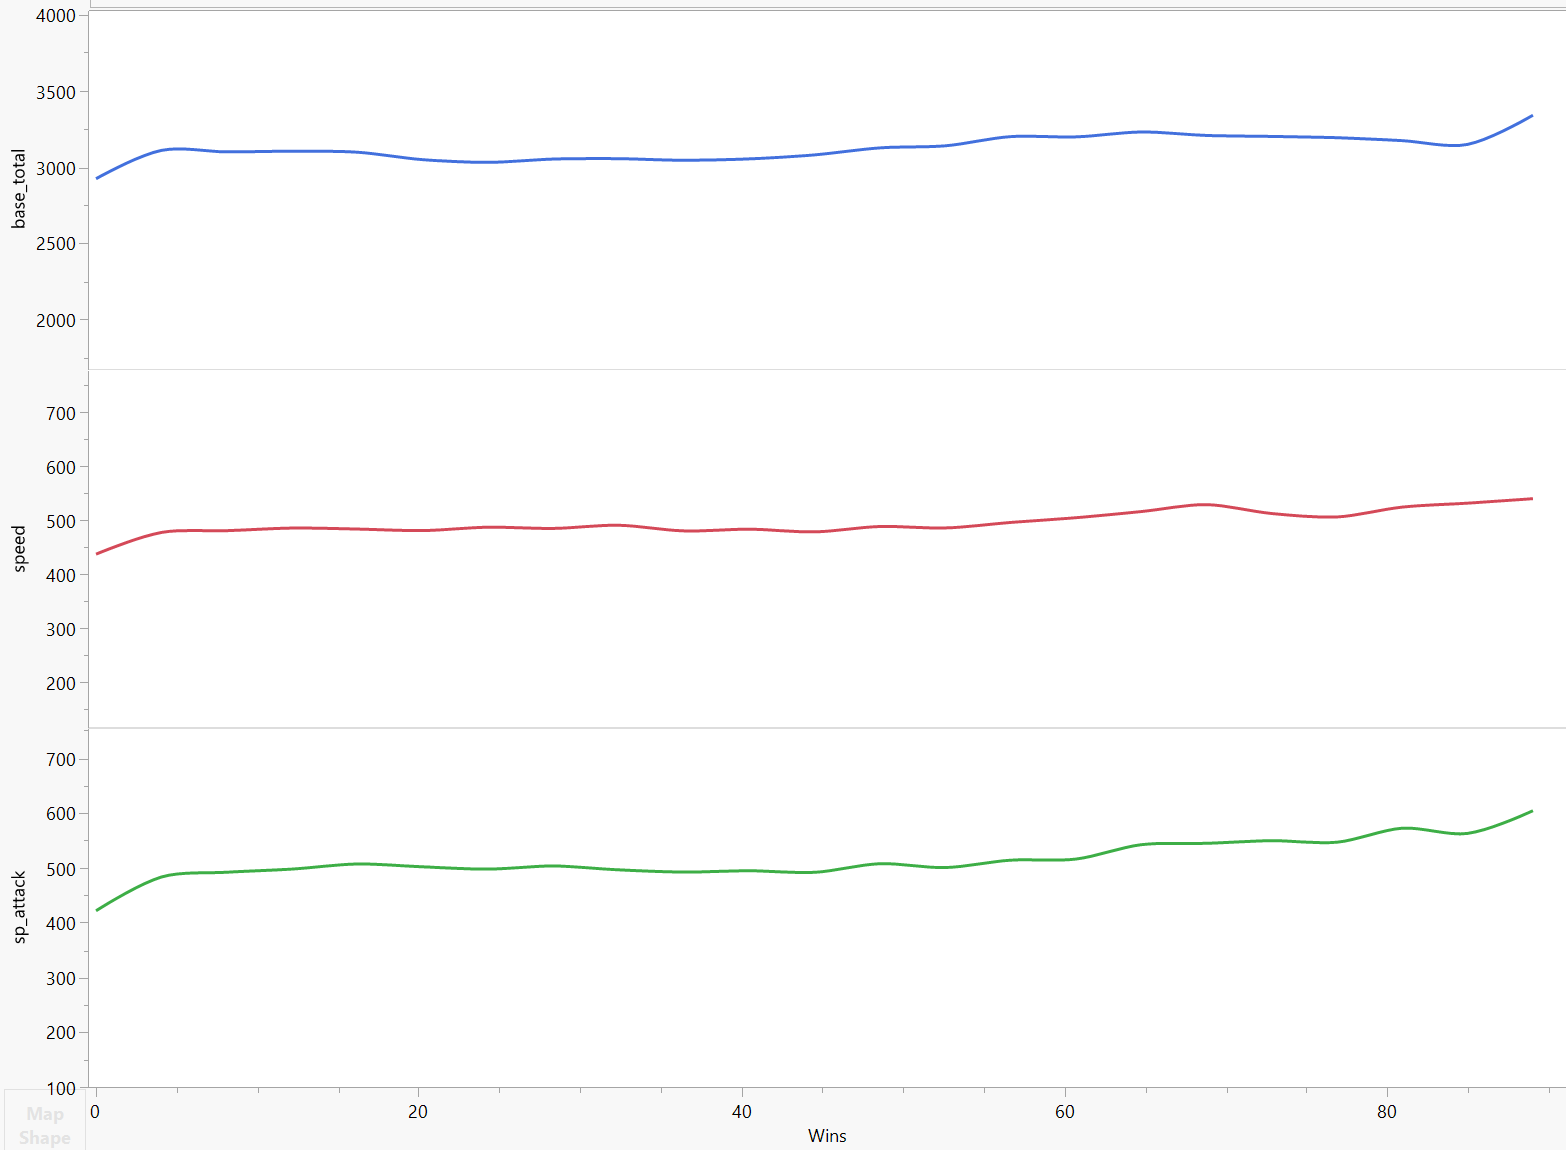

Horizontally compressed to illustrate upward trend more clearly <br>
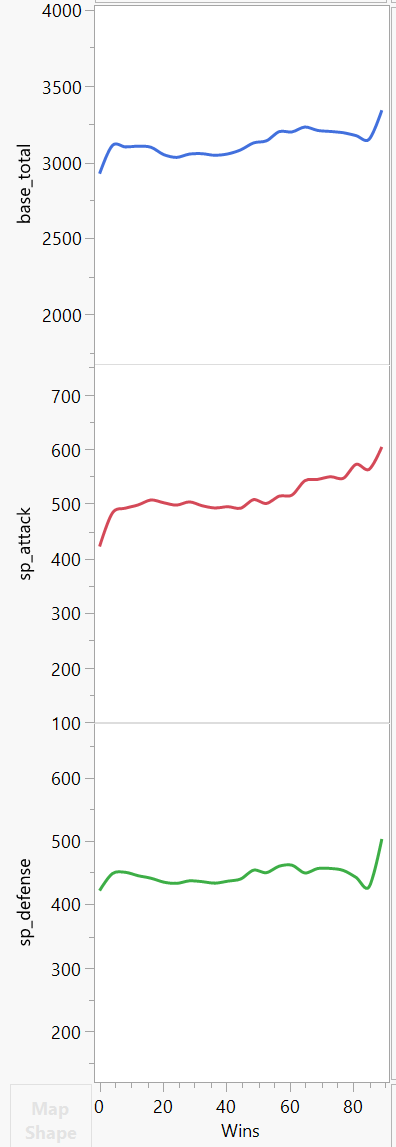

And with the individual data points also shown. <br>
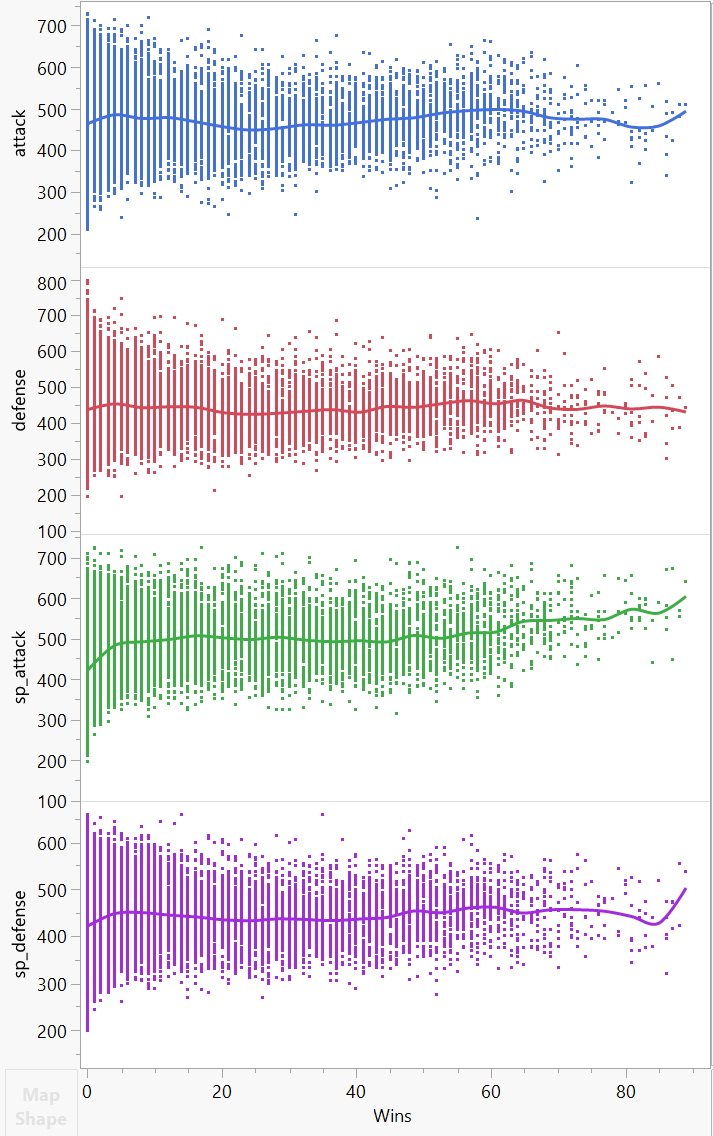

A contour plot in JMP showing the number of wins a team had vs the number of losses to each of the Elite Four. Lorelai clearly poses the highest threat to the majority of teams. <br>
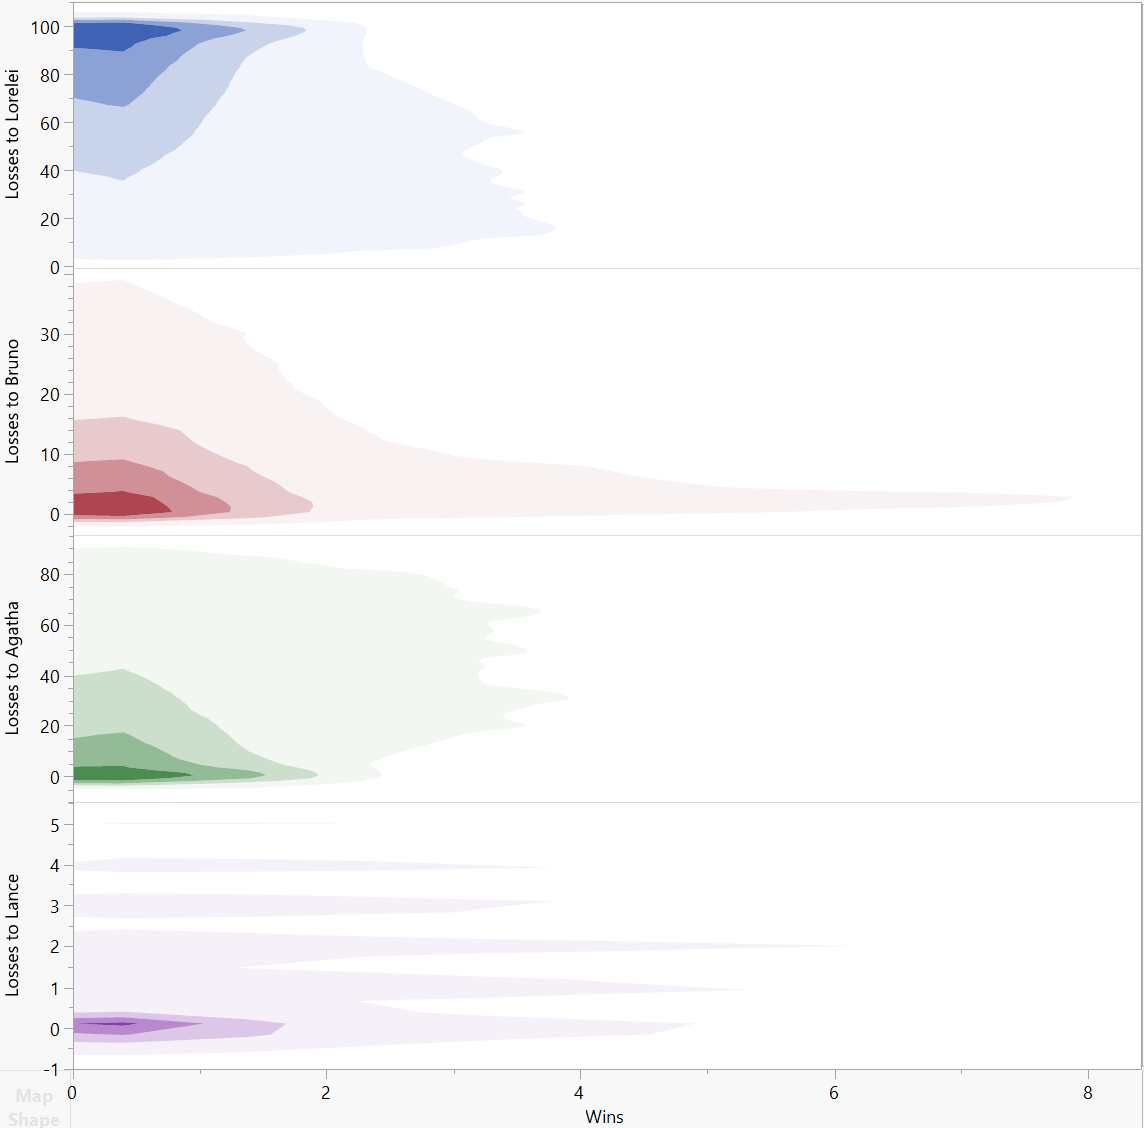

Another indication that higher stats tend to higher wins. Note that Special Attack has a clear correlation with wins, with certainty, but other stats have much more uncertaianty associated with them.
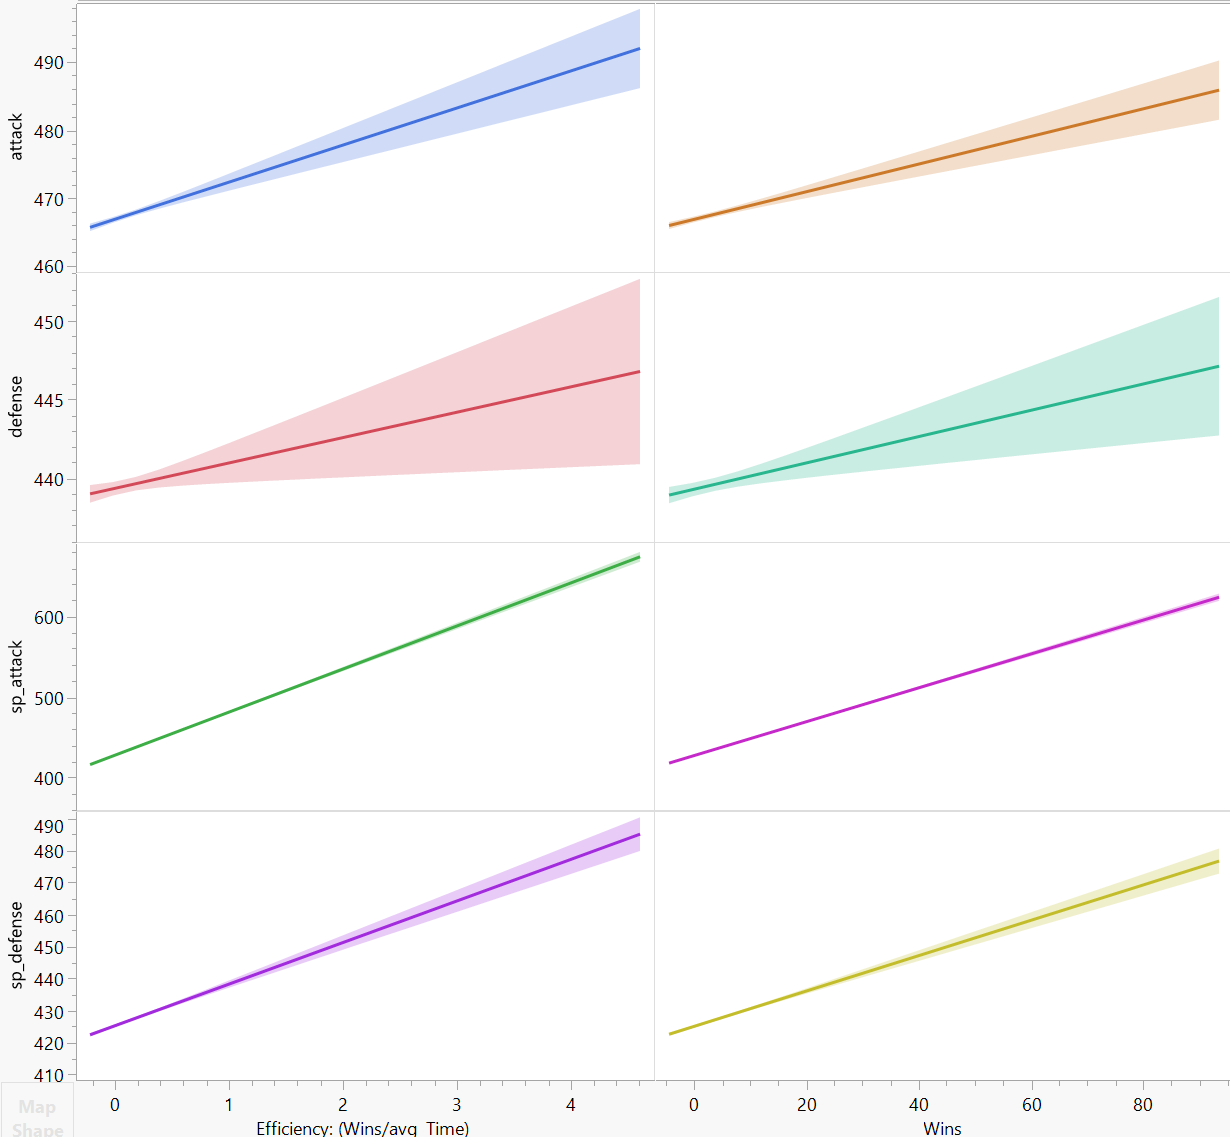

Honestly, a whole data project could be done on just the Random_Team_Summary.csv file.
